## 4. Multi-Document Agent

Till now, we had built an agent that can reason over a single document and answer complex queries while maintaining memory. 

Let's focus on increasing the number of documents and complexity of the queries too. 

Starting small with three and then eleven documents. 


In [1]:
from dotenv import load_dotenv
import nest_asyncio
import os
nest_asyncio.apply()
load_dotenv()

# Access variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

### Setup for 3 documents

We will use `get_doc_tools` that for a given paper, automatically builds both: 
- a vector index tool: performs vector search. 
- summary index tool: performs summarization over entire document. 

These are packed into a dictionary for each document mapping with vector tool and summary tool. 
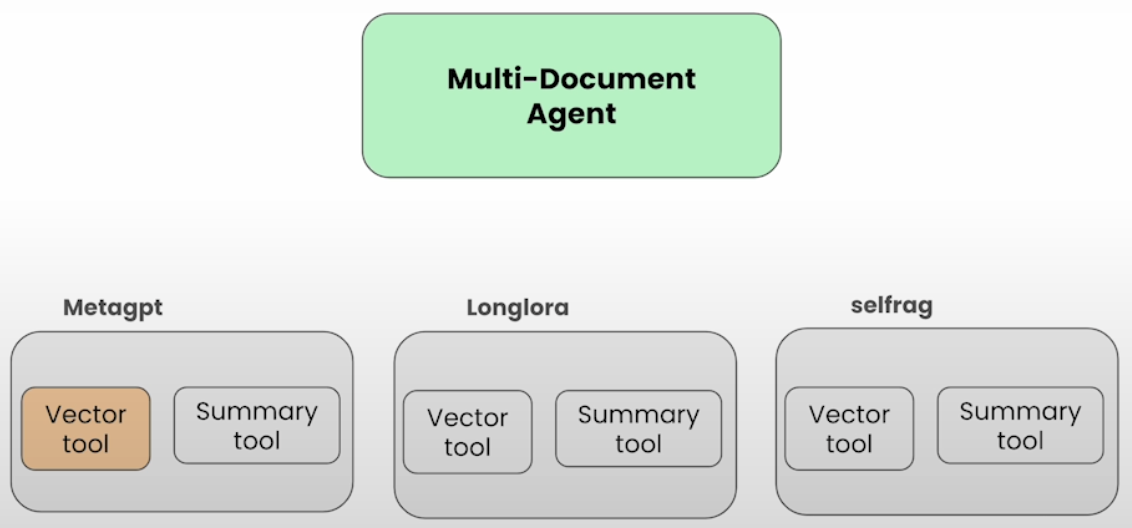

In [6]:
from utils4 import get_doc_tools
from pathlib import Path

urls = [
    "https://openreview.net/pdf?id=VtmBAGCN7o",
    "https://openreview.net/pdf?id=6PmJoRfdaK",
    "https://openreview.net/pdf?id=hSyW5go0v8",
]

papers = [
    "metagpt.pdf",
    "longlora.pdf",
    "selfrag.pdf",
]

paper_to_tools_dict = {}
for paper in papers:
    print(f"Getting tools for paper: {paper}")
    vector_tool, summary_tool = get_doc_tools(paper, Path(paper).stem)
    paper_to_tools_dict[paper] = [vector_tool, summary_tool]

Getting tools for paper: metagpt.pdf
Getting tools for paper: longlora.pdf
Getting tools for paper: selfrag.pdf


We have combined the vector and summary tools for each document into a list and passing it to agent. So the agent now has 6 tools in total, two for each document. 

We can convert them into a flat list.

In [10]:
initial_tools = [t for paper in papers for t in paper_to_tools_dict[paper]]
print("Number of tools: ", len(initial_tools))

Number of tools:  6


In [8]:
from llama_index.llms.openai import OpenAI

llm = OpenAI(model="gpt-3.5-turbo")

Now we will construct an overall agent worker consisting of llm and tools. So we will have the capability to ask question to a single document or within the 3 documents. 

In [11]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    initial_tools, 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)

Lets ask about a question about single document for now. 

In [12]:
response = agent.query(
    "Tell me about the evaluation dataset used in LongLoRA, "
    "and then tell me about the evaluation results"
)

Added user message to memory: Tell me about the evaluation dataset used in LongLoRA, and then tell me about the evaluation results
=== Calling Function ===
Calling function: vector_tool_longlora with args: {"query": "evaluation dataset"}
=== Function Output ===
PG19 test split
=== Calling Function ===
Calling function: vector_tool_longlora with args: {"query": "evaluation results"}
=== Function Output ===
The evaluation results show that the models achieve better perplexity with longer context sizes. Increasing the context window size leads to improved perplexity values. Additionally, the models are fine-tuned on different context lengths, such as 100k, 65536, and 32768, showcasing promising results on these large settings. However, there is some perplexity degradation observed on small context sizes for the extended models, which is a recognized limitation of Position Interpolation.
=== LLM Response ===
The evaluation dataset used in LongLoRA is the PG19 test split. 

Regarding the ev

Lets try to query two documents at once.

In [13]:
response = agent.query("Give me a summary of both Self-RAG and LongLoRA")
print(str(response))

Added user message to memory: Give me a summary of both Self-RAG and LongLoRA
=== Calling Function ===
Calling function: summary_tool_selfrag with args: {"input": "Self-RAG"}
=== Function Output ===
Self-RAG is a framework designed to enhance the quality and factuality of large language models by incorporating retrieval on demand and self-reflection. It involves training a Critic LM and a Generator LM to evaluate text using special tokens called reflection tokens. The Critic LM determines the need for retrieval based on input and output pairs, while the Generator LM generates reflection tokens accordingly. This system aims to produce responses that are well-supported by evidence, relevant to the task, and informative. Human evaluations have indicated that Self-RAG outputs are often plausible, backed by relevant evidence, and the predicted reflection tokens align closely with human assessments. The system's performance benefits from larger training data sizes and focuses on generating a

So we successfully found a way to query with multiple documents too. Lets try with 11 documents.

In [14]:
urls = [
    "https://openreview.net/pdf?id=VtmBAGCN7o",
    "https://openreview.net/pdf?id=6PmJoRfdaK",
    "https://openreview.net/pdf?id=LzPWWPAdY4",
    "https://openreview.net/pdf?id=VTF8yNQM66",
    "https://openreview.net/pdf?id=hSyW5go0v8",
    "https://openreview.net/pdf?id=9WD9KwssyT",
    "https://openreview.net/pdf?id=yV6fD7LYkF",
    "https://openreview.net/pdf?id=hnrB5YHoYu",
    "https://openreview.net/pdf?id=WbWtOYIzIK",
    "https://openreview.net/pdf?id=c5pwL0Soay",
    "https://openreview.net/pdf?id=TpD2aG1h0D"
]

papers = [
    "metagpt.pdf",
    "longlora.pdf",
    "loftq.pdf",
    "swebench.pdf",
    "selfrag.pdf",
    "zipformer.pdf",
    "values.pdf",
    "finetune_fair_diffusion.pdf",
    "knowledge_card.pdf",
    "metra.pdf",
    "vr_mcl.pdf"
]

Lets creating a mapping for the summary and vector tools for the documentats. 

In [16]:
paper_to_tools_dict = {}
for paper in papers:
    print(f"Getting tools for paper: {paper}")
    vector_tool, summary_tool = get_doc_tools(paper, Path(paper).stem)
    paper_to_tools_dict[paper] = [vector_tool, summary_tool]

Getting tools for paper: metagpt.pdf
Getting tools for paper: longlora.pdf
Getting tools for paper: loftq.pdf
Getting tools for paper: swebench.pdf
Getting tools for paper: selfrag.pdf
Getting tools for paper: zipformer.pdf
Getting tools for paper: values.pdf
Getting tools for paper: finetune_fair_diffusion.pdf
Getting tools for paper: knowledge_card.pdf
Getting tools for paper: metra.pdf
Getting tools for paper: vr_mcl.pdf


**Extend the Agent with Tool Retrieval**

We have a challenge here, as we keep on adding tools for multiple documnets, LLM context window will become longer. Also stuffing too many tool selections into the prompts leads to:

1. all the tools may not fit in the prompt.
   - In cases where we have too many documents and we model the each document as separate tool or set of tools. 
2. Cost and latency will spike if number of token are increased. 
3. Also, the LLM can get confused as it can fail to pick the right tool when given too many choices. 


**Solution:**
- When user asks a query, we perform the Retrieval Augmentation, but on the tool level, not on text levels. 
- So, we **first select a small set of relevant tools, which are then fed to agent reasoning promp**t instead of all the tools.  
- This retrieval process is similar to the retrieval process in RAG.
- For simplicity, we can only consider top k-vector search, but we can also add other advance retireval techniques to filter.


Lets, start with the process. 
- First we will index the tools, for this we can use llamaIndex that has indexing capabilities over textual documents. 
- These tools are python objects, so we need a way to convert and serialize these objects as string representations and back. This is solved using `ObjectIndex` abstraction in llamaIndex. 
- We will import a VectorStoreIndex which is standard interface for indexing text. Then we wrap this with object index. and in this object index, we plug in the python tools as input to the index. 

In [18]:
all_tools = [t for paper in papers for t in paper_to_tools_dict[paper]]

In [23]:
# define an "object" index and retriever over these tools
from llama_index.core import VectorStoreIndex
from llama_index.core.objects import ObjectIndex

obj_index = ObjectIndex.from_objects(
    all_tools,
    index_cls=VectorStoreIndex,
)

We can retrieve from the object index using object retriever. This calls the underlying retriever or from the index and return the output directly as objects. (here, this result will be tools.)

In [24]:
obj_retriever = obj_index.as_retriever(similarity_top_k=3)

tools = obj_retriever.retrieve(
    "Tell me about the eval dataset used in MetaGPT and SWE-Bench"
)

Lets explore the metadata of some of the tools. 

In [25]:
tools[0].metadata

ToolMetadata(description='Useful for summarization questions related to metagpt', name='summary_tool_metagpt', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)

In [26]:
tools[1].metadata

ToolMetadata(description='Useful for summarization questions related to metra', name='summary_tool_metra', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)

In [27]:
tools[2].metadata

ToolMetadata(description='Useful for summarization questions related to swebench', name='summary_tool_swebench', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)

Lets do the setup for FUNCTION CALLING AGENT. 

We can have a additional System Prompt that can have act as additional guidance if you want to prompt the agent to output in certain a way. 

In [28]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    tool_retriever=obj_retriever,
    llm=llm, 
    system_prompt=""" \
You are an agent designed to answer queries over a set of given papers.
Please always use the tools provided to answer a question. Do not rely on prior knowledge.\

""",
    verbose=True
)
agent = AgentRunner(agent_worker)

Lets ask some comparision queries. 

In [29]:
response = agent.query(
    "Tell me about the evaluation dataset used "
    "in MetaGPT and compare it against SWE-Bench"
)
print(str(response))

Added user message to memory: Tell me about the evaluation dataset used in MetaGPT and compare it against SWE-Bench
=== Calling Function ===
Calling function: summary_tool_metagpt with args: {"input": "evaluation dataset used in MetaGPT"}
=== Function Output ===
The evaluation dataset used in MetaGPT is the SoftwareDev dataset, which consists of 70 representative examples of software development tasks. These tasks cover diverse scopes such as mini-games, image processing algorithms, data visualization, creating games like Snake game, Brick breaker game, and 2048 game, developing programs for Excel data processing and CRUD management, as well as tasks like creating a music transcriber, custom press releases, Gomoku game, and a weather dashboard. The SoftwareDev dataset focuses on the engineering aspects and provides a robust testbed for authentic development tasks.
=== Calling Function ===
Calling function: summary_tool_swebench with args: {"input": "evaluation dataset used in SWE-Bench

We can see the calls made to `summary_tool_metagpt` and `summary_tool_swebench` and obtains respective results. Later we can see the final response as well. Lets tryout something else. 

In [30]:
response = agent.query(
    "Compare and contrast the LoRA papers (LongLoRA, LoftQ). "
    "Analyze the approach in each paper first. "
)

Added user message to memory: Compare and contrast the LoRA papers (LongLoRA, LoftQ). Analyze the approach in each paper first. 
=== Calling Function ===
Calling function: summary_tool_longlora with args: {"input": "LongLoRA"}
=== Function Output ===
LongLoRA is a versatile approach that enhances the context length of pre-trained large language models while maintaining high accuracy levels. It optimizes GPU memory usage and training time compared to traditional full fine-tuning methods by employing S2-Attn to approximate standard self-attention patterns during training. LongLoRA also facilitates the incorporation of trainable normalization and embedding layers, effectively bridging the gap between LoRA and full fine-tuning. This approach has demonstrated the ability to extend models like Llama2 7B to 100k context length and 70B models to 32k context length on a single 8×A100 machine.
=== Calling Function ===
Calling function: summary_tool_loftq with args: {"input": "LoftQ"}
=== Functio

From the output it can be seen the it has access to the tools from longLora and loftQ. Each of the repective tools give their output, that are later used to analyze in the final output. 